In [1]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
random.seed(2024)
dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

/home/csverst/Github/InterpretabilityBenchmark/


# Introduction to the Computation-Thru-Dynamics Benchmark
Hello! Welcome to the Computation-Thru-Dynamics Benchmark! In this tutorial, we'll be walking through the major features of CtD and how you can use it to test the ability of your data-trained models to accurately capture the dynamics of task-trained models. 

The four components of the CtD Benchmark are summarized in the figure below:
 - Task-training: Training a dynamics model to perform a task (e.g., motor control, memory)
 - Neural Data Simulation: Using a task-trained model to generate a simulated spiking dataset.
 - Data-training: Training a dynamics model on the simulated spiking data.
 - Comparison: Comparing the features (e.g., dynamics, latent activity) of task-trained and data trained models.

<img src="png/BenchmarkSchematicSimple-01.png" width="600" />


To demonstrate the usefulness of the benchmark, we're going to:
1. Train a task-trained network to perform a task
2. Simulate neural data from that network
3. Train a dynamics model on those data
4. Compare the dynamics of our data-trained models to the underlying dynamics of the task-trained network!

# Step 1: Task-Training
Let's begin by picking a simple task that we can train a model to perform.

![Easter Egg](png/TaskEnvs-01.png)

## N-Bit Flip-Flop
We're going to start out with the task that helped to launch this whole field, the N-Bit Flip-Flop. Sussillo et al. XXX used the three-bit flip-flop their seminal attempts to understand how dynamics can give rise to computation! 

The code snippet below intantiates an "TaskEnv" object, which contains the logic for the NBFF task. See the task_env documentation for more information on the requirements for creating your own task environments!

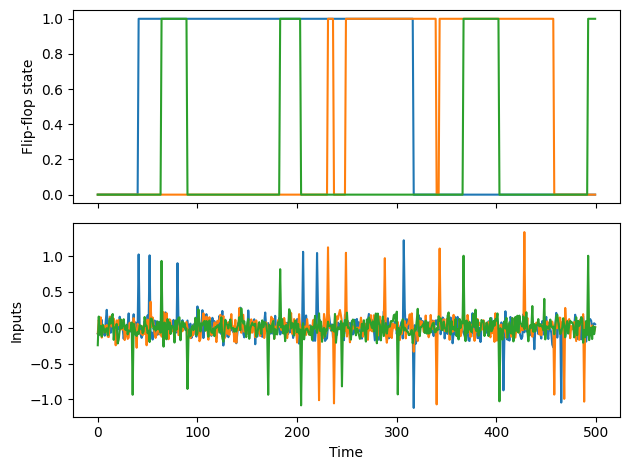

In [2]:
from interpretability.task_modeling.task_env.task_env import NBitFlipFlop

env_3bff = NBitFlipFlop(n = 3, n_timesteps=500, switch_prob=0.01, noise=0.1)
env_3bff.render()

Above, we are plotting the inputs and outputs of the 3BFF task. One trial is 500 time steps, each with a 1% probability of getting an "up" or "down" pulse on each of its 3 input channels. When the task receives an "up" pulse, the state corresponding to that input channel moves from zero to one (if possible), and if a state at one receives a "down" pulse, it goes to zero. In this way, this system acts as 3 bits of memory, encoding 8 potential system states (2^3 states). We add noise to the inputs of the system so that it better reflects realistic computations that a neural circuit might perform.

Another way to visualize this is to view the three states in 3D. Below you can see that the 8 potential states appear as the vertices of a cube. Each trial is plotted column. 

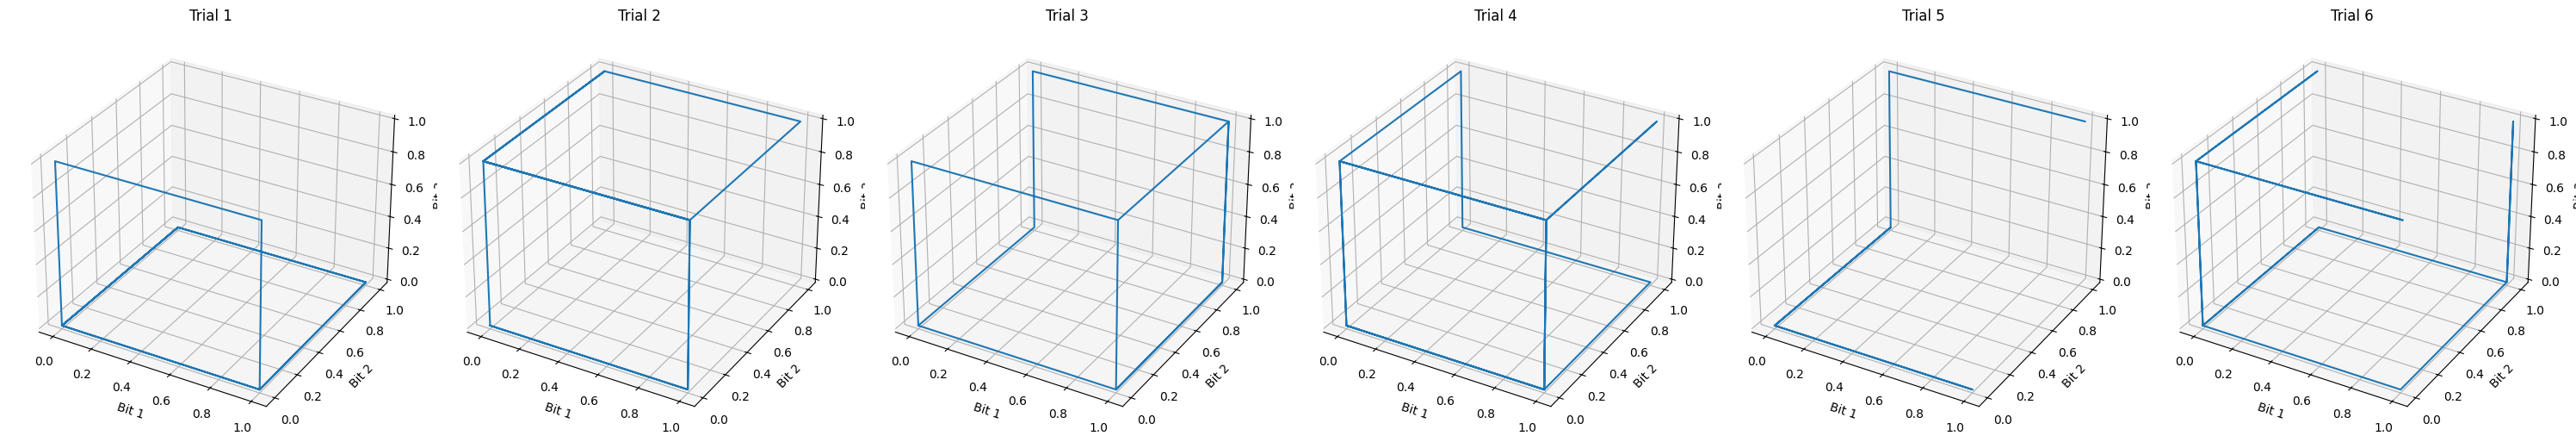

In [3]:
env_3bff.render_3d(n_trials=6)

Now that we've explored our task, let's train a model to perform it!

We use PyTorch Lightning to simplify this process, abstracting most of the training loop engineering so we can just deal with the models and tasks that we want to test. In general, PyTorchLightning takes in two objects, the LightningModule and the LightningDataModule which are provided by the Benchmark code-base. The only thing that you need to do is define your model class and your task environment.

The task environment is easy: we've defined the logic for the 3-bit Flip-Flop for you, but incorporating new tasks is simple!

In [4]:
# Create the task environment:
env_3bff = NBitFlipFlop(n = 3, n_timesteps=500, switch_prob=0.01, noise=0.1)
input_size = env_3bff.observation_space.shape[0] + env_3bff.context_inputs.shape[0]
output_size = env_3bff.action_space.shape[0]

The model will be an exercise for the tutorial. I've included a basic template for an recurrent network, and an example cell for performing the state update with rules for a Vanilla RNN.

In [5]:
import torch.nn as nn
import torch

class Vanilla_Cell(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.Whh = nn.Linear(latent_size, latent_size, bias=False)
        self.Wxh = nn.Linear(input_size, latent_size, bias=False)
        self.activation = nn.Tanh()
        self.bias = nn.Parameter(torch.zeros(latent_size))

    def forward(self, inputs, hidden=None):
        hidden = self.activation(self.Whh(hidden) + self.Wxh(inputs) + self.bias)
        return hidden
    
class Tutorial_RNN(nn.Module):
    def __init__(self, latent_size, input_size=None, output_size=None):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.output_size = output_size
        self.cell = None
        self.readout = None

    def init_model(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.cell = Vanilla_Cell(input_size, self.latent_size)
        self.readout = nn.Linear(self.latent_size, output_size)

    def forward(self, inputs, hidden=None):
        hidden = self.cell(inputs, hidden)
        output = self.readout(hidden)
        return output, hidden

# Create the task model:
model = Tutorial_RNN(latent_size=64)
model.init_model(input_size=input_size, output_size=output_size)

Now for the training! PyTorch Lightning makes this easy; we just need to create a LightningDatamodule (to handle train/validation splits) and a LightningModel (to handle looping logic and loss handling).

We also add a callback that generate diagnostic plots that help to assess training performance.

In [6]:

from interpretability.task_modeling.datamodule.task_datamodule import TaskDataModule
from interpretability.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from interpretability.task_modeling.callbacks.callbacks import StateTransitionTutorialCallback
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

import pytorch_lightning as pl

# Create the task datamodule:
dm = TaskDataModule(env_3bff, n_samples = 1000, batch_size = 1000)

# Create the task wrapper and set the environment and model:
wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay=1e-6)
wrapper.set_environment(env_3bff)
wrapper.set_model(model)

# Create the task callback and the tensorboard logger:
lg = TensorBoardLogger(save_dir="logs/", name="my_model")
cb = StateTransitionTutorialCallback(log_every_n_epochs=10)

# Train the task model:
trainer = pl.Trainer(max_epochs=10, callbacks=[cb], enable_progress_bar=False)
trainer.fit(wrapper, dm)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name  | Type         | Params
---------------------------------------
0 | model | Tutorial_RNN | 4.5 K 
---------------------------------------
4.5 K     Tra

To look at some tensorboard plots, open a terminal, navigate to the correct folder in lightning_logs, and enter tensorboard --logdir .

Once your model is done training, it should look something like this:
![Easter Egg](png/state_plot.png)

Unsurpisingly, with so few epochs of training, it doesn't look very good. Don't worry, we're going to pull in some pre-trained models so that our simulated brain can actually remember 3 bits :D

Let's see how well the model can perform the 3BFF task!

To do this, we're going to skip ahead a little bit and take a sneak peek at the Analysis class, which abstracts away much of the complexity of dealing with the models.

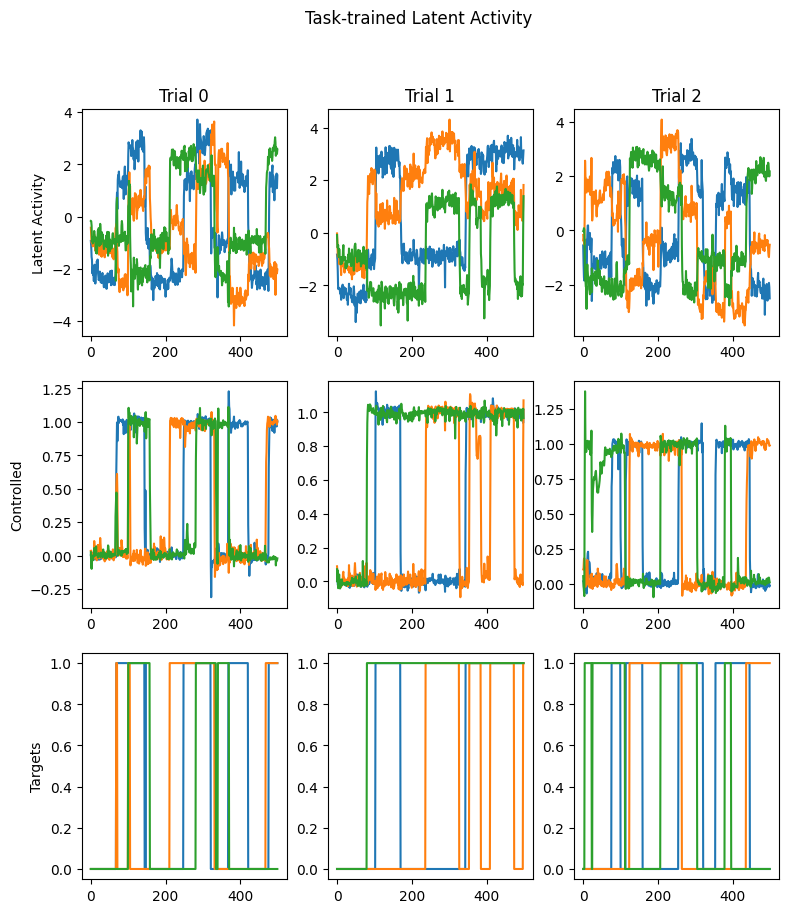

<Figure size 640x480 with 0 Axes>

In [7]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT

# Create the analysis object:
analysis = Analysis_TT(
    run_name = "tt_3BFF_pretrained", 
    filepath = "./pretrained_tt/")
analysis.plot_trial(num_trials=3, scatterPlot=False)

wrapper = analysis.wrapper

Top row represents the top 3 PCs of the latent activity
Middle row is the controlled output (what the model is attempting to match the targets)
Bottom row are the targeted control values.

As we can see, the model seems to be doing a pretty good job, but there seems to be things happening in the latent activity that are not reflected in the output.
Seems like this could potentially be an interesting dataset to examine!

# Step 2: Neural Data Simulation

Now that we have our RNN that is trained to perform three-bit flip-flop, we need to simulate the neural spiking activity.
For that, we are going to use the next object, called the Neural Data Simulator.

![Easter Egg](png/BenchmarkSchematicSimpleNeuralDS-01.png)

The neural data simulator is very simple; it takes in a datamodule and the trained model, and saves an .h5 file of neural firing rates to a location in your local directory where the data-trained models will be able to find it.

The process of simulating neural data has two steps:
1. Instantiate NeuralDataSimulator object with simulation parameters.
2. Pass the trained TT model, the datamodule that you want to simulate neural activity from, and some file paths to the simulate_neural_data method.

In the full code, the simulator is saved with the task-trained model so more neural activity can be simulated later if needed. Importantly, the datamodule used for simulation doesn't need to be the same datamodule used to train the model; this means allow for easy testing of generalizability of task-trained models.

Below is a schematic of the data simulation pipeline. See neural_simulator.py for information on the parameters and options for simulation.
![simulation](png/SimulationDiagram.png)

In [11]:
from interpretability.task_modeling.simulator.neural_simulator import NeuralDataSimulator
dm_sim = TaskDataModule(env_3bff, n_samples = 1000, batch_size = 1000, seed= 4096)
dm_sim.prepare_data()
dm_sim.setup()


dataset_path = pathlib.Path(HOME_DIR, "content", "datasets", "dt")
# Create the neural data simulator:
simulator = NeuralDataSimulator(
    n_neurons = 50,
    nonlin_embed=False,
)

simulator.simulate_neural_data(
    task_trained_model=wrapper,
    datamodule= dm_sim,
    run_tag = "tt_3BFF_pretrained",
    subfolder="seed=4096",
    dataset_path= dataset_path,
    seed= 4096,
)

![Data-training](png/BenchmarkSchematicSimpleDT-01.png)

In [20]:
from interpretability.data_modeling.datamodules.SAE.task_trained_data import TaskTrainedRNNDataModule
from interpretability.data_modeling.models.SAE.dyn_models_GRU import GRULatentSAE
import pickle
TRAINED_PATH = (
    "/home/csverst/Github/InterpretabilityBenchmark/content/"
    "trained_models/task-trained/20240225_NBFF_GRU_Tutorial/max_epochs=1000 seed=0/"
    )
# Create the datamodule:
dt_datamod = TaskTrainedRNNDataModule(prefix = "tt_3BFF_pretrained", system = "3BFF", gen_model="GRU_RNN", seed=4096)

# Create the model:
model = GRULatentSAE(
    dataset = "3BFF",
    encoder_size = 64,
    encoder_window = -1,
    heldin_size = 50,
    heldout_size= 50,
    latent_size= 128,
    lr = 1e-3,
    weight_decay = 1e-6,
    dropout = 0.05,
    input_size=3,
)

# Create the task callback and the tensorboard logger:
lg = TensorBoardLogger(save_dir="logs/", name="my_model_dt")

# Train the task model:
trainer = pl.Trainer(max_epochs=10, enable_progress_bar=False)
trainer.fit(wrapper, dm)

# Save the model and the datamodule as a pkl file:
dt_path = pathlib.Path(TRAINED_PATH, "dt")
os.mkdir(dt_path)

with open(os.path.join(dt_path, 'model.pkl'), "wb") as f:
    pickle.dump(model, f)

with open(os.path.join(dt_path, 'datamodule.pkl'), "wb") as f:
    pickle.dump(dt_datamod, f)
    

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name  | Type         | Params
---------------------------------------
0 | model | Tutorial_RNN | 4.5 K 
---------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
/home/csverst/miniconda3/envs/build5/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value

![comps](png/BenchmarkSchematicSimpleComparisons-01.png)

In [1]:
from interpretability.comparison.analysis.dt.dt import Analysis_DT
from interpretability.comparison.analysis.tt.tt import Analysis_TT

# Create the analysis object:
analysis_tt = Analysis_TT(
    run_name = "tt_3BFF_pretrained", 
    filepath = "./pretrained/tt/")

analysis_dt = Analysis_DT(
    run_name = "dt_3BFF_pretrained", 
    filepath = "./pretrained/dt/20240226_NBFF_GRU_DT/")


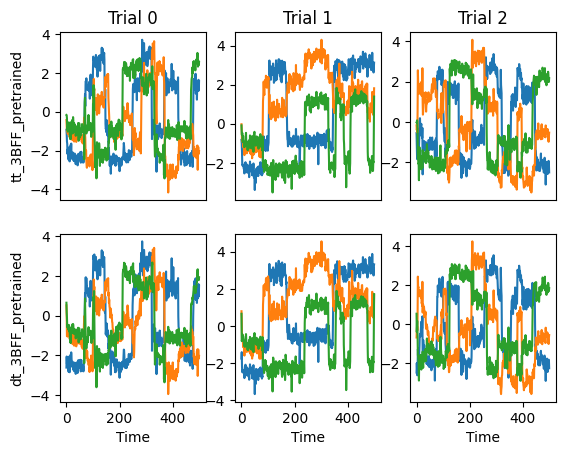

In [2]:
from interpretability.comparison.comparison import Comparison
comparison = Comparison()
comparison.load_analysis(analysis_tt, reference_analysis=True)
comparison.load_analysis(analysis_dt)

comparison.plot_trials_reference(num_trials=3)

array([[1.        , 0.93278017],
       [0.93255306, 0.99892064]])

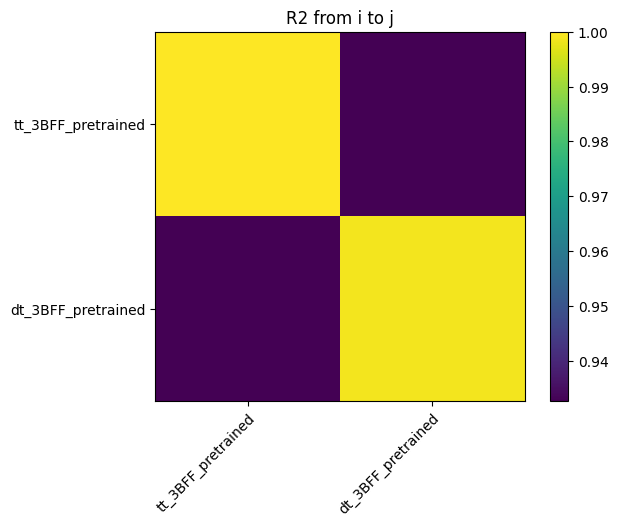

In [4]:
comparison.compare_state_r2()

In [3]:
comparison.compare_rate_r2()

AttributeError: 'Analysis_DT' object has no attribute 'get_rates'

In [4]:
analysis_dt.plot_fps(max_iters=30000,q_thresh=1e-7)

AttributeError: 'function' object has no attribute 'to'

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 1 and 0
Finished optimizing C
Finished optimizing C


array([[0.        , 0.11122471],
       [0.11122471, 0.        ]])

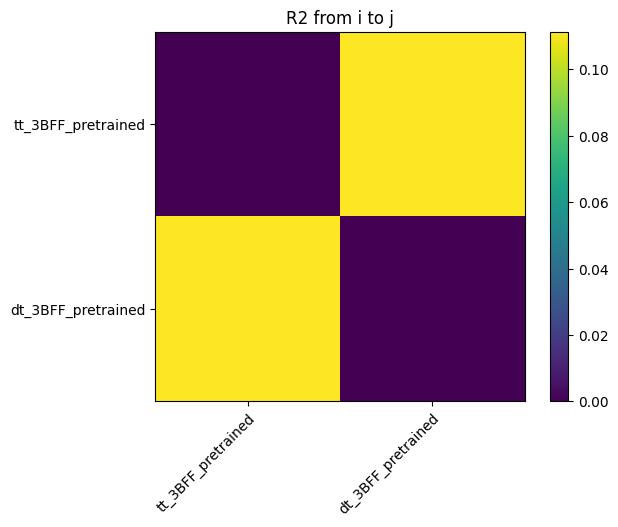

In [33]:
comparison.compare_dynamics_DSA(
    n_delays = 50, 
    rank = 200,
    percent_data=0.1,
    )